In [7]:
import datetime

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pandora.models.regression import WindowGenerator
from pandora.models.regression import Baseline
from pandora.models.regression import LinearModel

df = pd.read_csv('../data/moex/GAZP_processeddata.csv')
date_time = pd.to_datetime(df.pop('date_time'), format='%Y-%m-%d')
df.dropna(inplace=True)

print(date_time)
df.head()

0      2014-06-09
1      2014-06-10
2      2014-06-11
3      2014-06-16
4      2014-06-17
          ...    
1688   2021-02-20
1689   2021-02-22
1690   2021-02-24
1691   2021-02-25
1692   2021-02-26
Name: date_time, Length: 1693, dtype: datetime64[ns]


,open,low,high,close,vol,regAngle_8,regAngleInterpreter_8,regAngle_35,regAngleInterpreter_35,MA_fast,...,w1_WILLRdiv_long,w1_Hummer,w1_ShootingStar,w1_DivBar,w1_UpperTimeFrameCondition,sig_elder,sig_channel,sig_DivBar,sig_NR4ID,sig_breakVolatility
178,154.82,152.82,155.75,154.99,28730540,-41.757254,-1,19.255781,1,157.355834,...,-100.0,100.0,0.0,0.0,1.0,0,0,0.0,0,0
179,154.99,149.22,155.15,150.70,41502390,-62.052003,-2,19.587195,1,155.876760,...,-100.0,100.0,0.0,0.0,1.0,1,0,0.0,0,0
180,151.08,149.10,153.77,151.65,48571440,-64.993303,-2,17.862446,1,154.937480,...,-100.0,100.0,0.0,0.0,1.0,1,0,0.0,0,0
181,151.48,149.76,153.40,152.95,36636440,-65.800506,-2,17.770064,1,154.495818,...,-100.0,100.0,0.0,0.0,1.0,0,0,0.0,0,0
182,152.50,152.50,155.83,155.50,27953010,-62.461928,-2,17.119588,1,154.718969,...,-100.0,0.0,0.0,0.0,1.0,0,0,0.0,0,0


Точно так же столбец Date Time очень полезен, но не в этой строковой форме.
Начнем с преобразования в секунды

In [8]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Как и направление ветра, время в секундах не является полезным вводом модели.
Данные о погоде имеют четкую ежедневную и годовую периодичность. Есть много
способов справиться с периодичностью.

Простой способ преобразовать его в полезный сигнал - использовать sin и cos
для преобразования времени в сигналы «Время суток» и «Время года»:

Text(0.5, 1.0, 'Time of year signal')

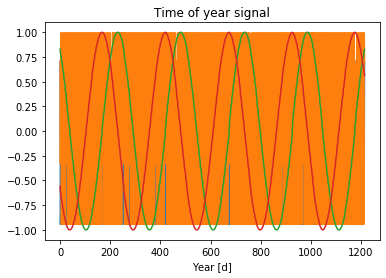

In [9]:
day = 24*60*60
week = 24*60*60*7
year = (365.2425)*day

df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Week sin'])[300:])
plt.plot(np.array(df['Week cos'])[300:])
plt.xlabel('Day [d]')
plt.title('Time of week signal')

plt.plot(np.array(df['Year sin'])[300:])
plt.plot(np.array(df['Year cos'])[300:])
plt.xlabel('Year [d]')
plt.title('Time of year signal')

Разделяем данные на сеты

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,1060.0,1.418340e+02,1.163461e+01,1.152900e+02,1.351075e+02,1.418950e+02,1.498400e+02,1.725300e+02
low,1060.0,1.403952e+02,1.137806e+01,1.114600e+02,1.339400e+02,1.404750e+02,1.480350e+02,1.721100e+02
high,1060.0,1.431798e+02,1.185215e+01,1.157500e+02,1.362700e+02,1.433350e+02,1.510075e+02,1.769500e+02
close,1060.0,1.418344e+02,1.166098e+01,1.153500e+02,1.349975e+02,1.419750e+02,1.496625e+02,1.721100e+02
vol,1060.0,2.826388e+07,1.310938e+07,1.581110e+06,1.991270e+07,2.577306e+07,3.364390e+07,1.207470e+08
...,...,...,...,...,...,...,...,...
sig_breakVolatility,1060.0,2.773585e-01,4.479063e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Week sin,1060.0,-3.005092e-01,6.000982e-01,-9.438833e-01,-8.467242e-01,-3.302791e-01,-1.119645e-01,9.937122e-01
Week cos,1060.0,2.031456e-01,7.135323e-01,-9.438833e-01,-3.302791e-01,5.320321e-01,7.071068e-01,9.937122e-01
Year sin,1060.0,3.347661e-02,7.208430e-01,-9.999999e-01,-6.934763e-01,5.692111e-02,7.693751e-01,9.999992e-01


In [11]:
# Нормализация данных
#train_mean = train_df.mean()
#train_std = train_df.std()

#train_df = (train_df - train_mean) / train_std
#val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

In [12]:
# Проверка качества нормализации
#df_std = (df - train_mean) / train_std
#df_std = df_std.melt(var_name='Column', value_name='Normalized')
#plt.figure(figsize=(12, 6))
#ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(df.keys(), rotation=90)


In [13]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                        label_columns=['close'], train_df=train_df,
                        val_df=val_df, test_df=test_df)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['close']

In [14]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close'], train_df=train_df,
                    val_df=val_df, test_df=test_df)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [15]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 65)
Inputs shape: (3, 6, 65)
labels shape: (3, 1, 1)


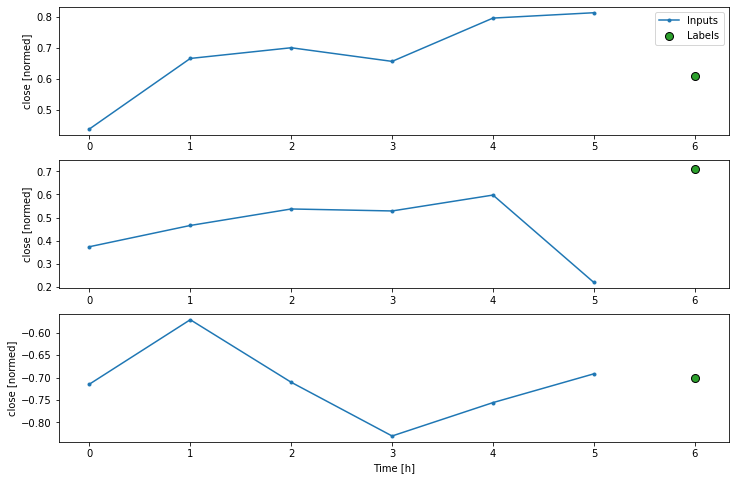

In [16]:
#w2.example = example_inputs, example_labels
w2.plot(plot_col='close')

In [17]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 65), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [18]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 65)
Labels shape (batch, time, features): (32, 1, 1)


## Одношаговая модель

In [19]:
single_step_window = WindowGenerator(   input_width=1,
                                        label_width=1,
                                        shift=1,
                                        label_columns=['close'],
                                        train_df=train_df,
                                        val_df=val_df,
                                        test_df=test_df)

print(single_step_window)

wide_window = WindowGenerator(  input_width=24,
                                label_width=24,
                                shift=1,
                                label_columns=['close'],
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df)

print(wide_window)

val_performance = {}
performance = {}

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']
Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']


10/10 [==============================] - 0s 940us/step - loss: 0.1121 - mean_absolute_error: 0.2312


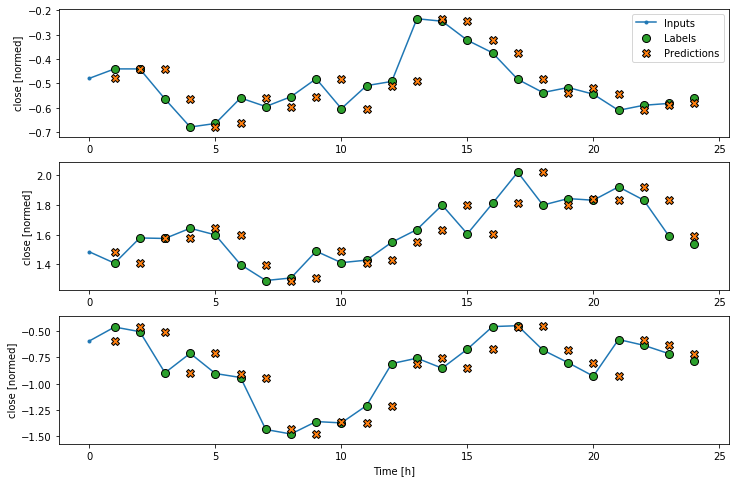

In [20]:
baseline = Baseline(label_index=column_indices['close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

wide_window.plot(plot_col='close', model=baseline)

Input shape: (32, 1, 65)
Output shape: (32, 1, 1)
Epoch 1/100
34/34 [==============================] - 0s 5ms/step - loss: 2.2170 - mean_absolute_error: 1.1751 - val_loss: 11.0098 - val_mean_absolute_error: 2.9597
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 0.9639 - mean_absolute_error: 0.7606 - val_loss: 3.4607 - val_mean_absolute_error: 1.5200
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6512 - mean_absolute_error: 0.6376 - val_loss: 2.5369 - val_mean_absolute_error: 1.2629
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 0.5952 - mean_absolute_error: 0.6034 - val_loss: 2.2478 - val_mean_absolute_error: 1.1854
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 0.5038 - mean_absolute_error: 0.5537 - val_loss: 2.1936 - val_mean_absolute_error

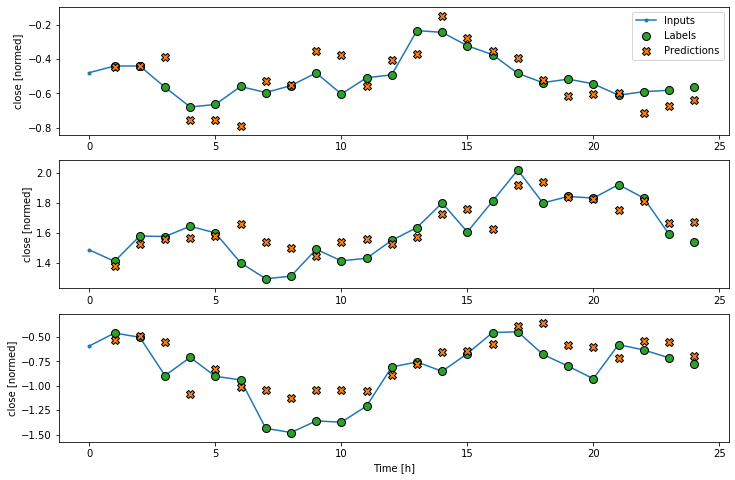

In [21]:
from pandora.models.regression import LinearModel

lm = LinearModel(single_step_window)
history =lm.compile_and_fit(patience=5)

val_performance['Linear'] = lm.model.evaluate(single_step_window.val)
performance['Linear'] = lm.model.evaluate(single_step_window.test,
                                                 verbose=0)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot('close', model=lm.model)

Input shape: (32, 1, 65)
Output shape: (32, 1, 1)
Epoch 1/100
34/34 [==============================] - 1s 5ms/step - loss: 0.6078 - mean_absolute_error: 0.5658 - val_loss: 2.2785 - val_mean_absolute_error: 1.3385
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0751 - mean_absolute_error: 0.2152 - val_loss: 0.6107 - val_mean_absolute_error: 0.6341
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0454 - mean_absolute_error: 0.1684 - val_loss: 0.5253 - val_mean_absolute_error: 0.5746
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0359 - mean_absolute_error: 0.1493 - val_loss: 0.5222 - val_mean_absolute_error: 0.5766
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0309 - mean_absolute_error: 0.1400 - val_loss: 0.6996 - val_mean_absolute_err

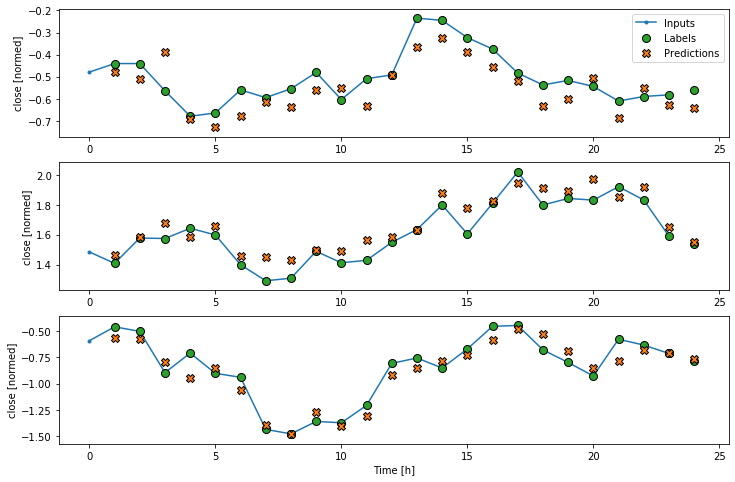

In [22]:
from pandora.models.regression import DenceModel

dm = DenceModel(single_step_window)
history = dm.compile_and_fit()

val_performance['Dence'] = dm.model.evaluate(single_step_window.val)
performance['Dence'] = dm.model.evaluate(single_step_window.test, verbose=0)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot('close', model=dm.model)

Input shape: (32, 24, 65)
Output shape: (32, 24, 1)
Epoch 1/100
33/33 [==============================] - 2s 15ms/step - loss: 0.6341 - mean_absolute_error: 0.5818 - val_loss: 32.2292 - val_mean_absolute_error: 5.3436
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0822 - mean_absolute_error: 0.2186 - val_loss: 31.2804 - val_mean_absolute_error: 5.2328

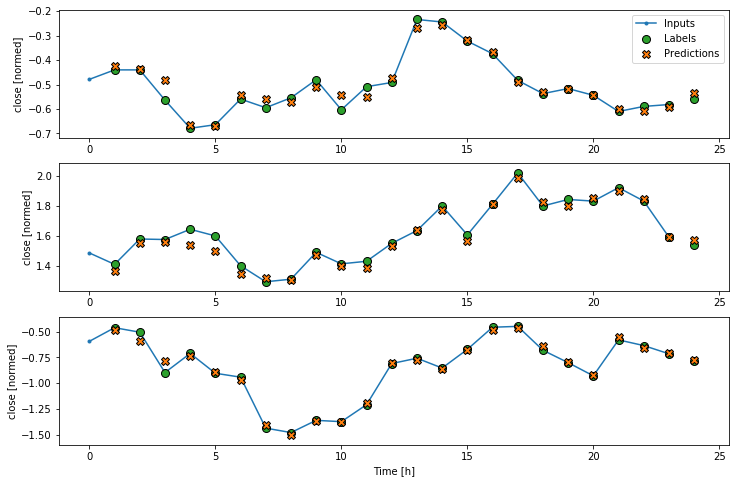

In [23]:
from pandora.models.regression import RecurrentNeuralNetwork
rnn = RecurrentNeuralNetwork(wide_window)
history = rnn.compile_and_fit()

val_performance['LSTM'] = rnn.model.evaluate(wide_window.val)
performance['LSTM'] = rnn.model.evaluate(wide_window.test, verbose=0)

wide_window.plot(plot_col='close', model=rnn.model)

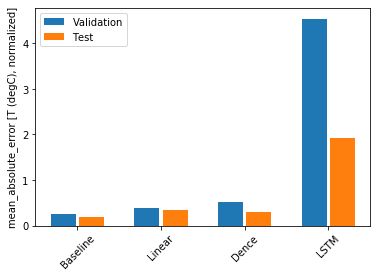

In [24]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = rnn.model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [25]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1973
Linear      : 0.3511
Dence       : 0.2945
LSTM        : 1.9112


### Multi

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28]
Label column name(s): None

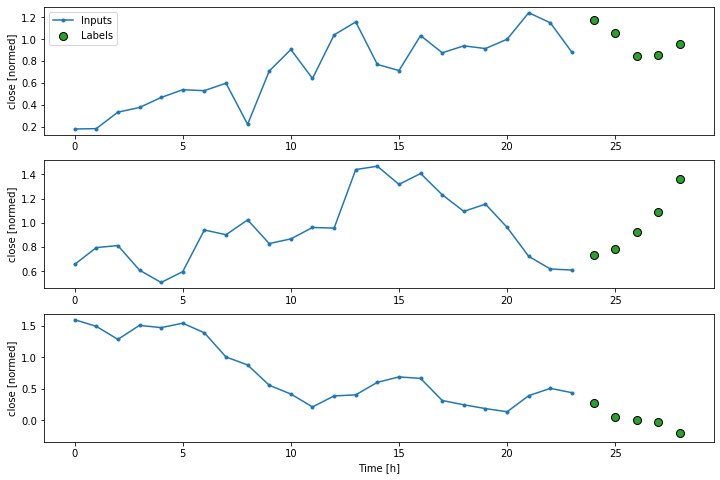

In [26]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df)

multi_val_performance = {}
multi_performance = {}

multi_window.plot(plot_col='close')
multi_window

9/9 [==============================] - 0s 770us/step - loss: 1.0772 - mean_absolute_error: 0.4602


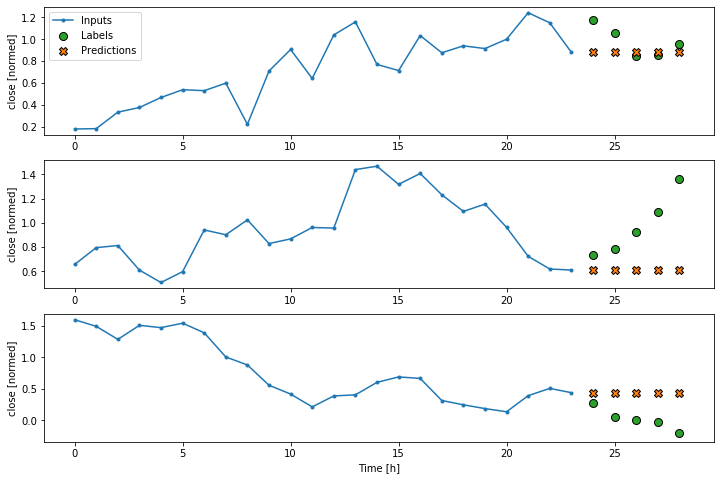

In [27]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='close', model=last_baseline)

Input shape: (32, 24, 65)
Output shape: (32, 5, 65)
Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 0.8695 - mean_absolute_error: 0.6714 - val_loss: 5.8470 - val_mean_absolute_error: 1.7454
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5875 - mean_absolute_error: 0.5330 - val_loss: 2.8578 - val_mean_absolute_error: 1.2361
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5136 - mean_absolute_error: 0.4731 - val_loss: 2.1119 - val_mean_absolute_error: 1.0364
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4937 - mean_absolute_error: 0.4545 - val_loss: 1.8536 - val_mean_absolute_error: 0.9539
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4776 - mean_absolute_error: 0.4446 - val_loss: 1.7408 - val_mean_absolute_err

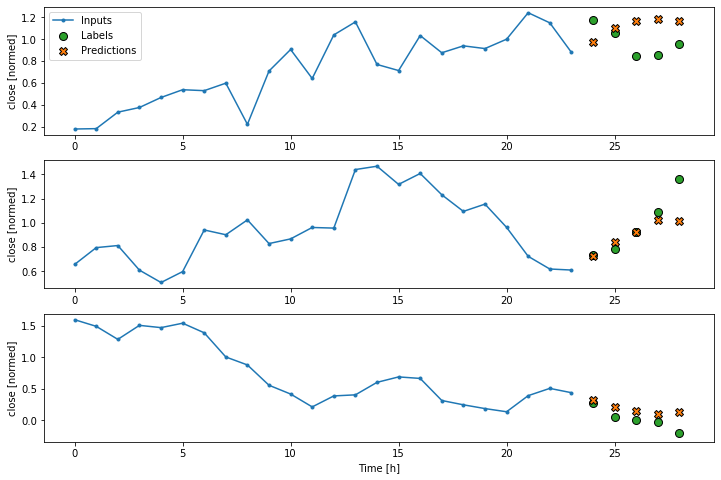

In [28]:
from pandora.models.regression import MultiLinearModel

mlm = MultiLinearModel(OUT_STEPS, multi_window, num_features)

history = mlm.compile_and_fit()

multi_val_performance['Linear'] = mlm.model.evaluate(multi_window.val)
multi_performance['Linear'] = mlm.model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='close', model=mlm.model)

Input shape: (32, 24, 65)
Output shape: (32, 5, 65)
Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 0.7563 - mean_absolute_error: 0.6091 - val_loss: 2.2707 - val_mean_absolute_error: 1.0971
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.4622 - mean_absolute_error: 0.4378 - val_loss: 1.9407 - val_mean_absolute_error: 0.9770
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.4161 - mean_absolute_error: 0.3960 - val_loss: 2.0658 - val_mean_absolute_error: 1.0168
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - los

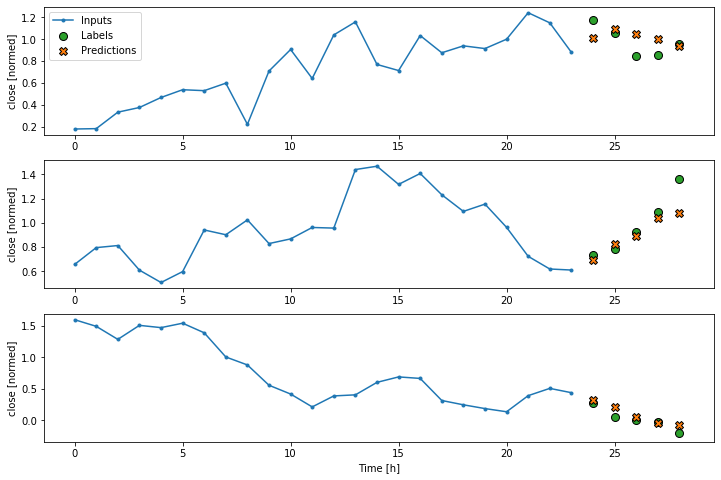

In [29]:
from pandora.models.regression import MultiDenceModel

mdm = MultiDenceModel(OUT_STEPS, multi_window, num_features)

history = mdm.compile_and_fit()

multi_val_performance['Dense'] = mdm.model.evaluate(multi_window.val)
multi_performance['Dense'] = mdm.model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='close', model=mdm.model)

Input shape: (32, 24, 65)
Output shape: (32, 5, 65)
Epoch 1/100
33/33 [==============================] - 2s 17ms/step - loss: 0.9591 - mean_absolute_error: 0.7029 - val_loss: 13.5040 - val_mean_absolute_error: 2.2410
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.7833 - mean_absolute_error: 0.6330 - val_loss: 12.2062 - val_mean_absolute_error: 2.1615

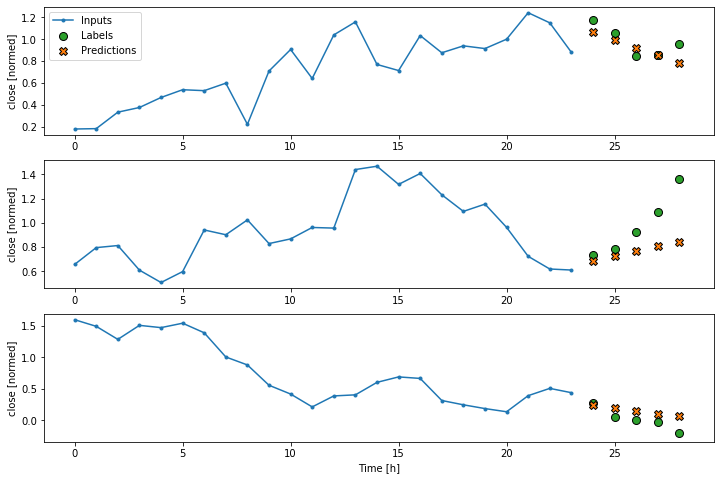

In [30]:
from pandora.models.regression import MultiRecurrentNeuralNetwork
mrnn = MultiRecurrentNeuralNetwork(OUT_STEPS, multi_window, num_features)

history = mrnn.compile_and_fit()

multi_val_performance['LSTM'] = mrnn.model.evaluate(multi_window.val)
multi_performance['LSTM'] = mrnn.model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='close', model=mrnn.model)

Output shape (batch, time, features):  (32, 5, 65)
Epoch 1/100
33/33 [==============================] - 2s 15ms/step - loss: 0.9913 - mean_absolute_error: 0.7383 - val_loss: 12.6706 - val_mean_absolute_error: 2.2033
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.7661 - mean_absolute_error: 0.6354 - val_loss: 11.5814 - val_mean_absolute_error: 2.1090

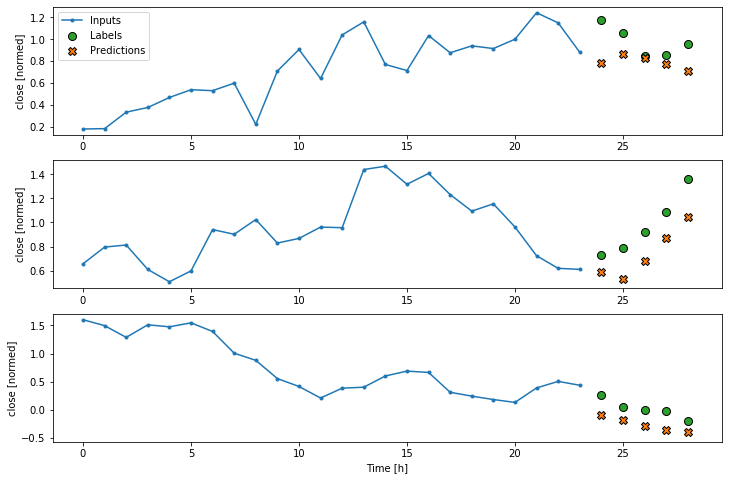

In [31]:
from pandora.models.regression import FeedBackRecurrentNeuralNetwork

feedback_model = FeedBackRecurrentNeuralNetwork(units=32,
                                                out_steps=OUT_STEPS,
                                                num_features=num_features)

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

history = feedback_model.compile_and_fit(window=multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='close', model=feedback_model)

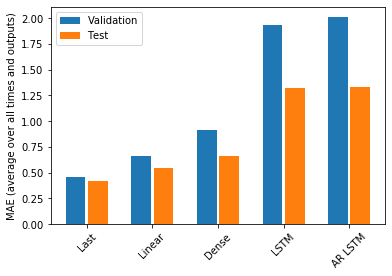

In [32]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = rnn.model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [33]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4193
Linear  : 0.5493
Dense   : 0.6640
LSTM    : 1.3201
AR LSTM : 1.3317


In [35]:
inp, lab = wide_window.example

predictions = rnn.model(inp)

#train_df_n = (train_df - train_mean) / train_std
#xxx = predictions * train_std.close + train_mean.close
print(wide_window.denormalize(predictions, 'close'))

tf.Tensor(
[[[136.90175 ]
  [136.73387 ]
  [136.23106 ]
  [134.08963 ]
  [134.0415  ]
  [135.48112 ]
  [135.32114 ]
  [135.17744 ]
  [135.89787 ]
  [135.5272  ]
  [135.39764 ]
  [136.29533 ]
  [138.7061  ]
  [138.84573 ]
  [138.13391 ]
  [137.56718 ]
  [136.13852 ]
  [135.66574 ]
  [135.79547 ]
  [135.48123 ]
  [134.836   ]
  [134.75592 ]
  [134.91492 ]
  [135.61124 ]]

 [[157.74205 ]
  [159.95331 ]
  [160.00739 ]
  [159.75775 ]
  [159.30922 ]
  [157.48512 ]
  [157.20831 ]
  [157.02896 ]
  [159.00026 ]
  [158.14326 ]
  [157.9531  ]
  [159.67043 ]
  [160.91113 ]
  [162.50677 ]
  [160.05295 ]
  [162.96797 ]
  [165.0249  ]
  [163.10423 ]
  [162.85187 ]
  [163.45761 ]
  [164.00322 ]
  [163.37868 ]
  [160.36461 ]
  [160.1633  ]]

 [[136.19608 ]
  [134.8984  ]
  [132.73813 ]
  [133.25699 ]
  [131.45934 ]
  [130.53285 ]
  [125.40037 ]
  [124.3147  ]
  [125.910675]
  [125.77732 ]
  [127.90642 ]
  [132.45222 ]
  [132.75948 ]
  [131.72635 ]
  [133.87582 ]
  [136.14037 ]
  [136.37978 ]
  [134.431